Many techniques in modern fluorescence microscopy--such as deconvolution and single molecule localization microscopy--rely on the computation of accurate microscope point spread functions (PSFs). Several models exist for these purposes with varying degrees of accuracy and generality. One such model, the so-called Gibson-Lanni model, approximates the PSF of an immersion microscope objective by accounting for the different refractive indexes of the immersion medium, coverslip, and sample, as well as variations in the thicknesses of the different layers. This post describes a Python implementation of a fast computational approach to the G&L PSF that was presented in **Fast and accurate three-dimensional point spread function computation for fluorescence microscopy** by Li, Xue, and Blu. The approach is fast because it avoids the need to perform any explicit integration of the Kirchhoff diffraction integral, such as is done in [PSF Generator](http://bigwww.epfl.ch/algorithms/psfgenerator/). The prototype is based on the manuscript and the associated MATLAB code at http://www.ee.cuhk.edu.hk/~tblu/monsite/phps/fastPSF.php

# References

- [Gibson, S. F., & Lanni, F. (1992). Experimental test of an analytical model of aberration in an oil-immersion objective lens used in three-dimensional light microscopy. JOSA A, 9(1), 154-166.](https://www.osapublishing.org/josaa/abstract.cfm?uri=josaa-9-1-154)
- [Li, J., Xue, F., & Blu, T. (2017). Fast and accurate three-dimensional point spread function computation for fluorescence microscopy. JOSA A, 34(6), 1029-1034.](https://www.osapublishing.org/josaa/fulltext.cfm?uri=josaa-34-6-1029&id=367116)
- [Kirshner, H. & Sage, D. (Accessed on October 20, 2017) PSF Generator](http://bigwww.epfl.ch/algorithms/psfgenerator/)

In [1]:
import sys
%pylab inline
import scipy.special
from scipy.interpolate import interp1d
from matplotlib import animation
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#272b30'
plt.rcParams['image.cmap'] = 'viridis'

print('Python {}\n'.format(sys.version))
print('NumPy\t\t{}'.format(np.__version__))
print('matplotlib\t{}'.format(matplotlib.__version__))
print('SciPy\t\t{}'.format(scipy.__version__))

Populating the interactive namespace from numpy and matplotlib
Python 3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]

NumPy		1.13.3
matplotlib	2.1.0
SciPy		0.19.1


# Simulation setup
## Define the simulation parameters

The Gibson-Lanni PSF model accounts for differences between design parameters and real parameters that describe the fluorescence microscope, such as the refractive indexes and thicknesses of the immersion medium, coverslip, and sample. For more information, please see the above references or, if you do not have access to the publications, the description of the model here: http://bigwww.epfl.ch/algorithms/psfgenerator/

In [2]:
# Image properties
# Size of the PSF array, pixels
size_x = 256
size_y = 256
size_z = 128

# Precision control
num_basis    = 100  # Number of rescaled Bessels that approximate the phase function
num_samples  = 1000 # Number of pupil samples along radial direction
oversampling = 2    # Defines the upsampling ratio on the image space grid for computations

# Microscope parameters
NA          = 1.4
wavelength  = 0.610 # microns
M           = 100   # magnification
ns          = 1.33  # specimen refractive index (RI)
ng0         = 1.5   # coverslip RI design value
ng          = 1.5   # coverslip RI experimental value
ni0         = 1.5   # immersion medium RI design value
ni          = 1.5   # immersion medium RI experimental value
ti0         = 150   # microns, working distance (immersion medium thickness) design value
tg0         = 170   # microns, coverslip thickness design value
tg          = 170   # microns, coverslip thickness experimental value
res_lateral = 0.1   # microns
res_axial   = 0.25  # microns
pZ          = 2     # microns, particle distance from coverslip

# Scaling factors for the Fourier-Bessel series expansion
min_wavelength = 0.436 # microns
scaling_factor = NA * (3 * np.arange(1, num_basis + 1) - 2) * min_wavelength / wavelength

## Create the coordinate systems

In [3]:
# Place the origin at the center of the final PSF array
x0 = (size_x - 1) / 2
y0 = (size_y - 1) / 2

# Find the maximum possible radius coordinate of the PSF array by finding the distance
# from the center of the array to a corner
max_radius = round(sqrt((size_x - x0) * (size_x - x0) + (size_y - y0) * (size_y - y0))) + 1;

# Radial coordinates, image space
r = res_lateral * np.arange(0, oversampling * max_radius) / oversampling

# Radial coordinates, pupil space
a = min([NA, ns, ni, ni0, ng, ng0]) / NA
rho = np.linspace(0, a, num_samples)

# Stage displacements away from best focus
z = res_axial * np.arange(-size_z / 2, size_z /2) + res_axial / 2

# Step 1: Approximate the pupil phase with a Fourier-Bessel series

`z.reshape(-1,1)` flips `z` from a row array to a column array so that it may be broadcast across `rho`.

The coefficients `C` are found by a least-squares solution to the equation

\begin{equation*}
\mathbf{\phi} \left( \rho , z \right)= \mathbf{J} \left( \rho \right) \mathbf{c} \left( z \right)
\end{equation*}

\\( \mathbf{c} \\) has dimensions `num_basis` \\( \times \\) `len(z)`. The `J` array has dimensions `num_basis` \\( \times \\) `len(rho)` and the `phase` array has dimensions `len(z)` \\( \times \\) `len(rho)`. The `J` and `phase` arrays are therefore transposed to get the dimensions right in the call to `np.linalg.lstsq`.

In [4]:
# Define the wavefront aberration
OPDs = pZ * np.sqrt(ns * ns - NA * NA * rho * rho) # OPD in the sample
OPDi = (z.reshape(-1,1) + ti0) * np.sqrt(ni * ni - NA * NA * rho * rho) - ti0 * np.sqrt(ni0 * ni0 - NA * NA * rho * rho) # OPD in the immersion medium
OPDg = tg * np.sqrt(ng * ng - NA * NA * rho * rho) - tg0 * np.sqrt(ng0 * ng0 - NA * NA * rho * rho) # OPD in the coverslip
W    = 2 * np.pi / wavelength * (OPDs + OPDi + OPDg)

# Sample the phase
# Shape is (number of z samples by number of rho samples)
phase = np.cos(W) + 1j * np.sin(W)

# Define the basis of Bessel functions
# Shape is (number of basis functions by number of rho samples)
J = scipy.special.jv(0, scaling_factor.reshape(-1, 1) * rho)

# Compute the approximation to the sampled pupil phase by finding the least squares
# solution to the complex coefficients of the Fourier-Bessel expansion.
# Shape of C is (number of basis functions by number of z samples).
# Note the matrix transposes to get the dimensions correct.
C, residuals, _, _ = np.linalg.lstsq(J.T, phase.T)

## Compare the function to its Fourier-Bessel expansion

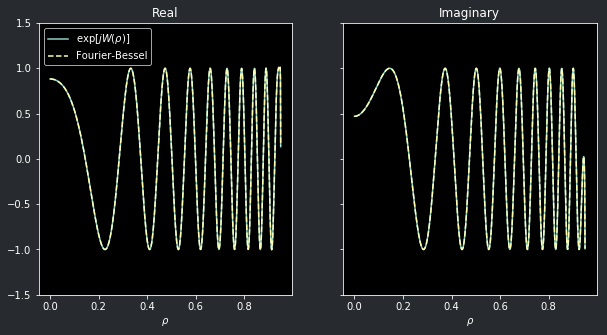

In [5]:
# Which z-plane to compute
z0 = 24

# The Fourier-Bessel approximation
est = J.T.dot(C[:,z0])

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
ax[0].plot(rho, np.real(phase[z0, :]), label=r'$ \exp{ \left[ jW \left( \rho \right) \right] }$')
ax[0].plot(rho, np.real(est), '--', label='Fourier-Bessel')
ax[0].set_xlabel(r'$\rho$')
ax[0].set_title('Real')
ax[0].legend(loc='upper left')

ax[1].plot(rho, np.imag(phase[z0, :]))
ax[1].plot(rho, np.imag(est), '--')
ax[1].set_xlabel(r'$\rho$')
ax[1].set_title('Imaginary')
ax[1].set_ylim((-1.5, 1.5))

plt.show()

# Step 2: Compute the PSF

Here, we use the Fourier-Bessel series expansion of the phase function and a Bessel integral identity to compute the approximate PSF. Each coefficient \\( c_{m} \left( z \right) \\) needs to be multiplied by

\begin{equation*}
R \left(r; \mathbf{p} \right) = \frac{\sigma_m J_1 \left( \sigma_m a \right) J_0 \left( \beta a \right)a - \beta J_0 \left( \sigma_m a \right) J_1 \left( \beta a \right)a }{\sigma_m^2 - \beta^2}
\end{equation*}

and the resulting products summed over the number of basis functions. \\( \mathbf{p} \\) is the parameter vector for the Gibson-Lanni model, \\( \sigma_m \\) is the scaling factor for the argument to the \\( m'th \\) Bessel basis function, and \\( \beta = kr\text{NA} \\).

`b` is defined such that `R` has dimensions of `len(r)` \\( \times \\) `len(rho)`.

In [6]:
b = 2 * np. pi * r.reshape(-1, 1) * NA / wavelength

# Convenience functions for J0 and J1 Bessel functions
J0 = lambda x: scipy.special.jv(0, x)
J1 = lambda x: scipy.special.jv(1, x)

# See equation 5 in Li, Xue, and Blu
denom = scaling_factor * scaling_factor - b * b
R = (scaling_factor * J1(scaling_factor * a) * J0(b * a) * a - b * J0(scaling_factor * a) * J1(b * a) * a)
R /= denom

Now compute the point-spread function via

\begin{equation*}
PSF \left( r, z; z_p, \mathbf{p} \right) = \left| \mathbf{R} \left( r; \mathbf{p} \right) \mathbf{c} \left( z \right) \right|^2
\end{equation*}

In [7]:
# The transpose places the axial direction along the first dimension of the array, i.e. rows
# This is only for convenience.
PSF_rz = (np.abs(R.dot(C))**2).T

# Normalize to the maximum value
PSF_rz /= np.max(PSF_rz)

## Profile in r and z

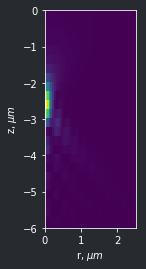

In [8]:
fig, ax = plt.subplots()

ax.imshow(PSF_rz, extent=(r.min(), r.max(), z.max(), z.min()))
ax.set_xlim((0,2.5))
ax.set_ylim((-6, 0))
ax.set_xlabel(r'r, $\mu m$')
ax.set_ylabel(r'z, $\mu m$')

plt.show()

z is the stage *displacement* in an inverted microscope. So, negative z's correspond to moving "up" in the sample.

# Step 3: Resample the PSF onto a rotationally-symmetric Cartesian grid

Here we generate a two dimensional grid where the value at each grid point is the distance of the point from the center of the grid. These values are supplied to an interpolation function computed from `PSF_rz` to produce a rotationally-symmetric 2D PSF at each z-position.

In [9]:
# Create the fleshed-out xy grid of radial distances from the center
xy      = np.mgrid[0:size_y, 0:size_x]
r_pixel = np.sqrt((xy[1] - x0) * (xy[1] - x0) + (xy[0] - y0) * (xy[0] - y0)) * res_lateral

PSF = np.zeros((size_y, size_x, size_z))

for z_index in range(PSF.shape[2]):
    # Interpolate the radial PSF function
    PSF_interp = interp1d(r, PSF_rz[z_index, :])
    
    # Evaluate the PSF at each value of r_pixel
    PSF[:,:, z_index] = PSF_interp(r_pixel.ravel()).reshape(size_y, size_x)

# Save z-stack to a movie

In [10]:
fig, ax    = plt.subplots(nrows=1, ncols=1)

# Rescale the PSF values logarithmically for better viewing
PSF_log = np.log(PSF)
vmin, vmax = PSF_log.min(), PSF_log.max()

img = ax.imshow(PSF[:,:,64], vmin=vmin, vmax=vmax)
img.set_extent([-r.max(), r.max(), -r.max(), r.max()])

txt = ax.text(3, 7, 'z = {:.1f} $\mu m$'.format(z[64]))
ax.set_xlim((-8, 8))
ax.set_xticks((-5, 0, 5))
ax.set_xlabel(r'x, $\mu m$')
ax.set_ylim((-8, 8))
ax.set_yticks((-5, 0, 5))
ax.set_ylabel(r'y, $\mu m$')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Initialize the figure with an empty frame
def init():
    img.set_data(np.zeros((size_y, size_x)))
    return img,

# This function is called for each frame of the animation
def animate(frame):   
    img.set_data(np.log(PSF[:, :, frame]))

    txt.set_text('z = {:.1f} $\mu m$'.format(z[frame]))
    return img,

# Create the animation
anim = animation.FuncAnimation(fig, animate, frames=len(z),
                               init_func=init, interval=20, blit=True)

# Save the animation
myWriter = animation.FFMpegWriter(fps=10, extra_args=['-vcodec', 'libx264'])
anim.save('gibson-lanni.mp4', writer = myWriter)
    
plt.close()

<video controls src="../gibson-lanni.mp4" type="video/mp4" />

# Summary

In summary, this method for calculating the Gibson-Lanni PSF is fast because it reduces the problem to a numer of matrix operations, rather than a numerical integration of the Kirchhoff diffraction integral. I especially find the Fourier-Bessel approximation of the phase function very clever, since this enables us to apply the integral identity described above. Moreover, it seems like the approach can extend to computing PSFs from other wavefront aberrations, though at the moment I do not know how it might handle non-rotationally symmetric pupils. (I am referring to the `W` variable above.)

I would like to thank the first author of the work, [Jizhou Li](http://www.ee.cuhk.edu.hk/~jzli/), for encouraging me to write this as a blog post and for providing feedback on the implementation presented here.